In [2]:
# Importing libraries needed for data cleaning and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import scattertext as st
from IPython.display import IFrame

In [3]:
menslib = pd.read_csv('./datasets/menslib.csv')

In [4]:
mensrights = pd.read_csv('./datasets/mensrights.csv')

Now that we have our data, the key question now is to what to do with it, or how to make it interpretable to our computers. Because the text we just gathered is unstructured data, we need to make sure that our text is clean and free of null values or duplicated entries. This entails removing URL links and non-alphanumerical characters that won't be useful in a classification model.

This notebook will focus mainly on data cleaning and processing, as well as analysis of Ngrams and sentiment from each subreddit.

# Inital Analysis

In [5]:
mensrights.describe()

,upvotes,upvote_ratio,n_comments,distinguished
count,775.000000,775.000000,775.000000,0.0
mean,233.428387,0.890903,24.954839,NaN
std,1059.403182,0.125913,53.944648,NaN
min,0.000000,0.050000,0.000000,NaN
25%,11.000000,0.860000,2.000000,NaN
50%,25.000000,0.930000,8.000000,NaN
75%,64.000000,0.970000,23.000000,NaN
max,23012.000000,1.000000,619.000000,NaN


In [6]:
menslib.describe()

,upvotes,upvote_ratio,n_comments
count,1000.000000,1000.000000,1000.00000
mean,556.424000,0.925860,89.47400
std,863.952033,0.075507,114.67019
min,0.000000,0.390000,0.00000
25%,41.000000,0.910000,16.00000
50%,122.500000,0.950000,44.00000
75%,800.250000,0.970000,117.25000
max,6534.000000,1.000000,760.00000


'Hot' or popular posts from `r/MensRights` have an average of 233 upvotes, with around 25 comments per post. In comparison, posts from `r/MensLib` have an average of 595 upvotes, and 91 comments per post. Based on this, it seems that the `r/MensLib` community is a lot more active.

However, it's worth noting that `r/MensRights` has 286,000 subscribers compared to the 152,000 subscribers of `r/MensLib`, so we can't base popularity off these statistics alone.

In [7]:
# 75 mod posts
menslib['distinguished'].isin(['moderator']).sum()

75

In [8]:
# 0 mod posts!
mensrights['distinguished'].isin(['moderator']).sum()

0

When it comes to top posts, `r/MensLib` has 75 posts from moderators, while `r/MensRights` has 0. This could suggest that the moderators of `r/MensLib` are more active than that of `r/MensRights`.

Before we begin, let's check for null values and duplicate posts.

In [9]:
# Check for null values
menslib.isnull().sum()[menslib.isnull().sum() > 0]

selftext         337
distinguished    925
author            37
dtype: int64

In [10]:
mensrights.isnull().sum()[mensrights.isnull().sum() > 0]

selftext         433
distinguished    775
author             4
dtype: int64

In [11]:
# Deal with null values
menslib['selftext'] = menslib['selftext'].fillna('')
mensrights['selftext'] = mensrights['selftext'].fillna('')

In [12]:
# Check for duplicates
duplicates = menslib[(menslib.duplicated(subset=['selftext'])) & (menslib['selftext'] != '')] \
                .sort_values(ascending=False, by='selftext') \
                ['title'].value_counts()

duplicates

Weekly Free Talk Friday thread!                                                                                   19
Tuesday Check In: How's Everybody's Mental Health?                                                                17
Weekly Free Talk Friday Thread!                                                                                   14
Tuesday Check In: How's Everyone's Mental Health?                                                                 11
Happy International Men's Day from MensLib                                                                         1
Musing on masculinity and coopetition.                                                                             1
Anyone else struggle to make friends?                                                                              1
Facing patriarchal sexual shame and worthlessness                                                                  1
Tuesday Check In: How's everyone's mental health?               

In [13]:
# No duplicates!
mensrights[(mensrights.duplicated(subset=['selftext'])) & (mensrights['selftext'] != '')] \
                .sort_values(ascending=False, by='selftext')['title'].value_counts()

Series([], Name: title, dtype: int64)

In [14]:
menslib = menslib.drop_duplicates(subset=['title'])

In [15]:
# Check for any more duplicates
duplicates = menslib[(menslib.duplicated(subset=['selftext'])) & (menslib['selftext'] != '')] \
                .sort_values(ascending=False, by='selftext') \
                ['title'].value_counts()

duplicates

Tuesday Check-In: How's everyone's mental health?    1
Tuesday Check In: How's Everyone's Mental Health?    1
Name: title, dtype: int64

In [16]:
# Dropping weekly threads that are mod posts
menslib = menslib.drop(menslib[menslib['title'].str.contains('Weekly Free Talk')].index)
menslib = menslib.drop(menslib[menslib['title'].str.contains('Tuesday Check')].index)
menslib = menslib.drop(menslib[menslib['title'].str.contains('NEW Resources of The Week Highlight')].index)

To conduct further analysis in areas such as word and ngram frequency, we'll first have to clean the data by removing http links and irrelevant non alpha-numeric characters.

In [17]:
def drop_links(text):
    words = text.split(' ')
    words_to_sub = [w for w in words if 'http' in w]
    
    if words_to_sub:
        for w in words_to_sub:
            new_word = re.sub('http.*', '', w)
            text = re.sub(w, new_word, text)
        return text
        
    # If no links in post, return text   
    return text

In [18]:
def preprocessing(text):
            
    # Remove new lines
    text = text.replace('\n',' ').lower()
    
    # Remove emoticons
    text = re.sub(':d', '', str(text)).strip()
    text = re.sub(':p', '', str(text)).strip()
    
    # Remove HTML markers and punctuation
    text = re.sub('xa0', '', str(text)).strip()
    text = re.sub('x200b', '', str(text)).strip()
    text = re.sub('[^a-zA-Z\s]', '', str(text)).strip() 
    
    return text

I've also created a function that creates a lemmatized version of my text -- lemmatization helps to reduce inflectional forms and derivationally related forms of a word to a common base form. This function however, is only for reference as using a lemmatized version of my text led to a decreased level of accuracy during model testing.

Research has generally shown that that [lemmatization is not necessary](https://www.aclweb.org/anthology/W19-6203.pdf), especially for languages with a simple morphology (like English).

In [19]:
stop_word_set = set(CountVectorizer(stop_words = 'english').get_stop_words())

def lemmatize(text):
    # Change each word to a string to prepare for lemmatization
    words = text.split(' ')
    
    # Lemmatize words.
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if not w in stop_word_set]
    
    return(" ".join(meaningful_words))

# Data Cleaning & Preprocessing

In [20]:
# Removing new lines, removing punctuation and tokenizing text for menslib
menslib['cleaned_title'] = menslib['title'].apply(preprocessing)
menslib['cleaned_selftext'] = menslib['selftext'].apply(preprocessing)


# Removing new lines, removing punctuation and tokenizing text for mensrights
mensrights['cleaned_title'] = mensrights['title'].apply(preprocessing)
mensrights['cleaned_selftext'] = mensrights['selftext'].apply(preprocessing)

In [21]:
# Dropping links
menslib['cleaned_selftext'] = menslib['cleaned_selftext'].apply(drop_links)
mensrights['cleaned_selftext'] = mensrights['cleaned_selftext'].apply(drop_links)

In [22]:
# Combining title and selftext
menslib['combi_text'] = menslib['cleaned_title'] + ' ' + menslib['cleaned_selftext']
mensrights['combi_text'] = mensrights['cleaned_title'] + ' ' + mensrights['cleaned_selftext']

In [23]:
# Lemmatizing text for menslib & mensrights
menslib['lem_title'] = menslib['cleaned_title'].apply(lemmatize, True)
menslib['lem_selftext'] = menslib['cleaned_selftext'].apply(lemmatize, True)
menslib['lem_combi_text'] = menslib['lem_title'] + ' ' + menslib['lem_selftext']

mensrights['lem_title'] = mensrights['cleaned_title'].apply(lemmatize, True)
mensrights['lem_selftext'] = mensrights['cleaned_selftext'].apply(lemmatize, True)
mensrights['lem_combi_text'] = mensrights['lem_title'] + ' ' + mensrights['lem_selftext']

In [24]:
# Comparing lemmatized vs regular text 
# We can see that a lot of nuance within the post has been lost after lemmatization and removal of stop words
print(menslib['combi_text'][0], '\n')
print(menslib['lem_combi_text'][0])

happy international mens day from menslib officially the theme is better health for men and boys however us at the mod team feel thats a bit corporate and sanitised in how it sounds in our opinion the real theme has to be the issue that we have all been thinking about every single day since march of this year the current global pandemic  so lets all kick off our shoes let our hair down a bit and talk about this year how its affected our lives our mental health and what were doing to cope remember that we all need to be looking after each other out there 

happy international men day menslib officially theme better health men boy mod team feel thats bit corporate sanitised sound opinion real theme issue thinking single day march year current global pandemic  let kick shoe let hair bit talk year affected life mental health doing cope remember need looking


In [25]:
# Final check for null values -- distinguished and author aren't important for our model so we can leave them as they are
mensrights.isnull().sum()[mensrights.isnull().sum() > 0]

distinguished    775
author             4
dtype: int64

In [26]:
mensrights.shape, menslib.shape

((775, 16), (890, 16))

Our classes are slightly imbalanced, but this is somewhat to be expected given differences between each subreddit due to factors such as strict automoderation policies or Reddit's internal algorithm.

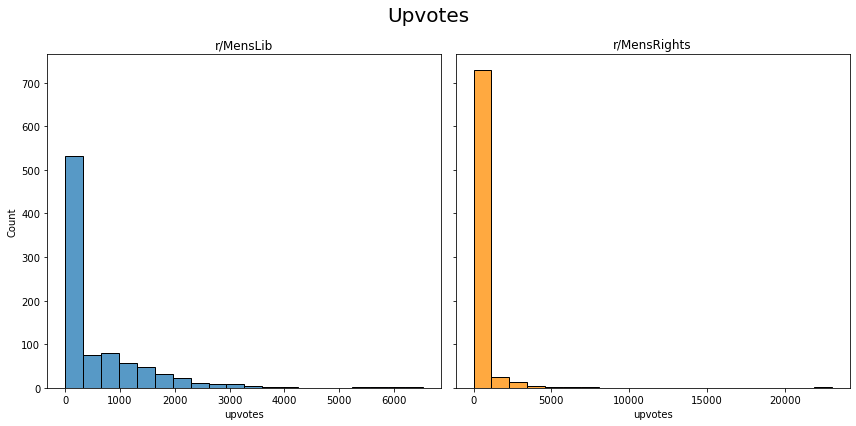

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax = ax.ravel()
g1 = sns.histplot(data=menslib, x='upvotes', ax = ax[0], bins=20)
g1.set_title('r/MensLib')
g2 = sns.histplot(data=mensrights, x='upvotes', ax = ax[1], bins=20, color='darkorange')
g2.set_title('r/MensRights')
plt.suptitle('Upvotes', fontsize=20)
plt.tight_layout()

While both subreddits have a large number of posts that have less than 2000 upvotes, the majority of posts from `r/MensRights` have less than 1,000 upvotes. We can see that posts in `r/MensLib` are more evenly distributed, though still skewed towards the right. `r/MensRights` has an outlier post that reached over 20,000 upvotes.

In [28]:
mensrights[mensrights['upvotes'] > 20_000]

,date,title,selftext,is_self,upvotes,upvote_ratio,n_comments,distinguished,permalink,author,cleaned_title,cleaned_selftext,combi_text,lem_title,lem_selftext,lem_combi_text
673,7/11/2020 22:23,Petition to have Amber Heard removed as the L'...,,False,23012,0.91,619,NaN,/r/MensRights/comments/jprmy5/petition_to_have...,sj20442,petition to have amber heard removed as the lo...,,petition to have amber heard removed as the lo...,petition amber heard removed loreal spokesperson,,petition amber heard removed loreal spokesperson


This post is likely to have made it to the front page of Reddit and resonated with readers there. Public sentiment of Johnny Depp has been mostly positive since the trial, with many redditors upset over Johnny Depp's treatment by the media and companies like Disney. This is a rallying issue for `r/MensRights`, which focuses heavily on [false accusations of rape or sexual assault](https://www.reddit.com/r/MensRights/search?q=false%20accusation&restrict_sr=1) made against men.

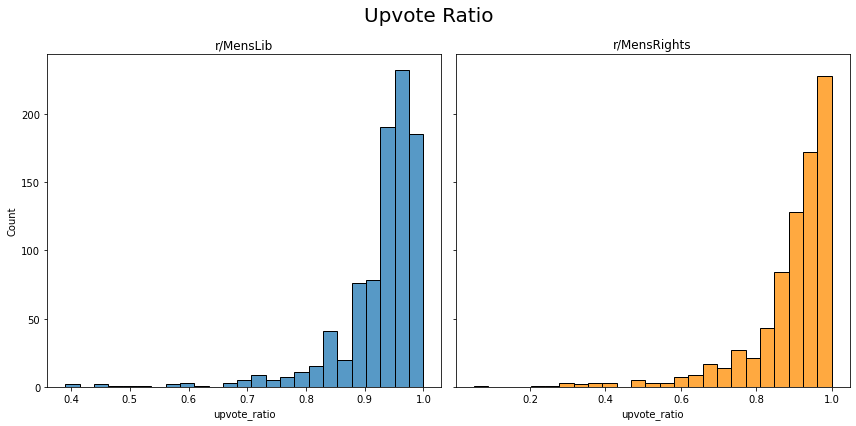

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax = ax.ravel()
g1 = sns.histplot(data=menslib, x='upvote_ratio', ax = ax[0], bins=25)
g1.set_title('r/MensLib')
g2 = sns.histplot(data=mensrights, x='upvote_ratio', ax = ax[1], bins=25, color='darkorange')
g2.set_title('r/MensRights')
plt.suptitle('Upvote Ratio', fontsize=20)
plt.tight_layout()

We can see that the `r/MensLib` posts seem to have a slightly more dynamic upvote ratio. For `r/MensRights`, the high upvote ratio is probably due to the fact that most posts don't attract much attention outside of the sub given their average upvotes within the sub don't bring posts to Reddit's front page often.

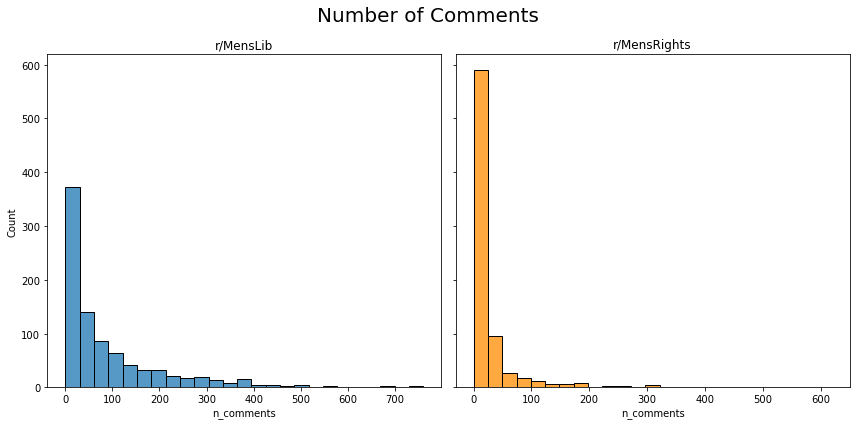

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax = ax.ravel()
g1 = sns.histplot(data=menslib, x='n_comments', ax = ax[0], bins=25)
g1.set_title('r/MensLib')
g2 = sns.histplot(data=mensrights, x='n_comments', ax = ax[1], bins=25, color='darkorange')
g2.set_title('r/MensRights')
plt.suptitle('Number of Comments', fontsize=20)
plt.tight_layout()

The community of `r/MensLib` seems to be a lot more active than that of `r/MensRights`, despite the higher subscriber count of the latter.

# Exploratory Data Analysis

Let's look at the distribution of our features for both subreddits.

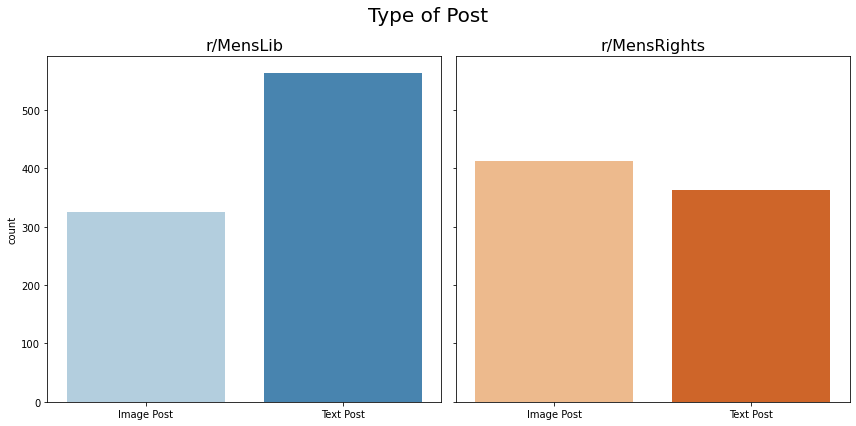

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax = ax.ravel()
g1 = sns.countplot(data=menslib, x=menslib['is_self'].astype(int), ax = ax[0], palette='Blues')
g1.set_xticklabels(['Image Post', 'Text Post'])
g1.set_title('r/MensLib', fontsize=16)
g1.set_xlabel('')
g2 = sns.countplot(data=mensrights, x=mensrights['is_self'].astype(int), ax = ax[1], palette='Oranges')
g2.set_xticklabels(['Image Post', 'Text Post'])
g2.set_title('r/MensRights', fontsize=16)
g2.set_ylabel('')
g2.set_xlabel('')
plt.suptitle('Type of Post', fontsize=20)
plt.tight_layout()

A large number of posts in `r/MensRights` are not text posts. `R/MensLib` also has a substantial number of non-text posts. As we created a feature that combines both title text and post text (`combi_text`), this shouldn't pose much of an issue to our model later on.

## Analyzing Title and Post Length

In [32]:
def subplot_histograms(col, graph_title):
    fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
    ax = ax.ravel()
    
    # Plot first df   
    g1 = sns.histplot(data=menslib, x=menslib[col].str.len(), ax = ax[0], bins=25)
    mean_1 = menslib[col].str.len().mean()
    ax[0].axvline(mean_1, ls='--', color='black')
    g1.set_title(f'r/MensLib (Mean: {round(mean_1)} words)')
    g1.set_xlabel(f'Length of {col.capitalize()}')
    
    # Plot second df
    g2 = sns.histplot(data=mensrights, x=mensrights[col].str.len(), ax = ax[1], bins=25, color='darkorange')
    mean_2 = mensrights[col].str.len().mean()
    ax[1].axvline(mean_2, ls='--', color='black')
    g2.set_title(f'r/MensRights (Mean: {round(mean_2)} words)')
    g2.set_xlabel(f'Length of {col.capitalize()}')
    plt.suptitle(graph_title, fontsize=20)
    plt.tight_layout()

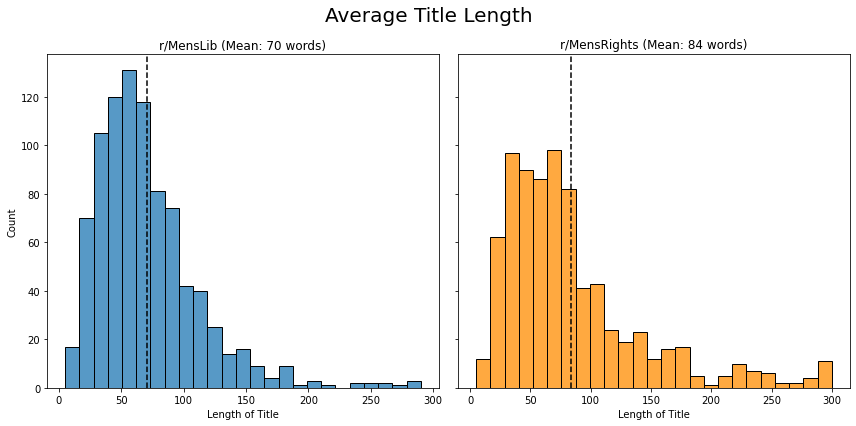

In [33]:
subplot_histograms('title', 'Average Title Length')

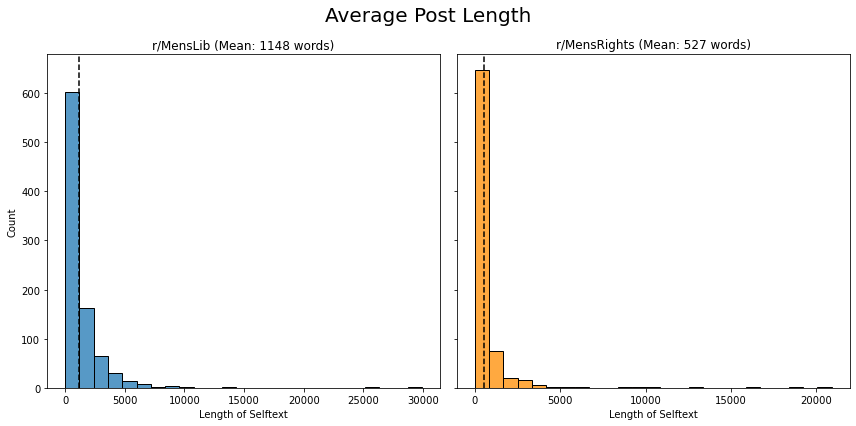

In [34]:
subplot_histograms('selftext', 'Average Post Length')

`r/MensLib` generally has slightly shorter title lengths than `r/MensRights`, but the average post length in `r/MensLib` is much greater than the average post length in `r/MensRights`. The differences here could make these features useful for our classifier model.

## Analyzing Ngrams

To analyze the lanaguage within each subreddit, I took a bag-of-words approach, where each word is broken into units (or tokenized) and counted according to how often this given word appears in a post. 

This approach is called a 'bag' of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document. Within this process, we'll also look to remove frequent words that don’t contain much information, like 'a,' 'of,' etc. These are known as stop words.

To do this, we'll be using <b>CountVectorizer()</b>, a scikit-learn tool that helps to both tokenize a collection of text documents and build a vocabulary of known words and encode new documents using that vocabulary. We'll also be using it to exclude stopwords from our results.

### Top Words

In [35]:
# Create function to get top words
def plot_top_words(df, col, n, n_gram_range, title, palette='tab10'):
    def get_top_n_words(corpus, n=n, k=n_gram_range):     
        vec = CountVectorizer(ngram_range=(k,k), stop_words='english').fit(corpus)     
        bag_of_words = vec.transform(corpus)     
        sum_words = bag_of_words.sum(axis=0)      
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]    
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
        return words_freq[:n]
    temp_df = pd.DataFrame(data=get_top_n_words(df[col], n), columns=['word','freq'])
    plt.figure(figsize=(10,6))
    sns.barplot(data=temp_df, y='word', x='freq', palette=palette)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title, fontsize=18)

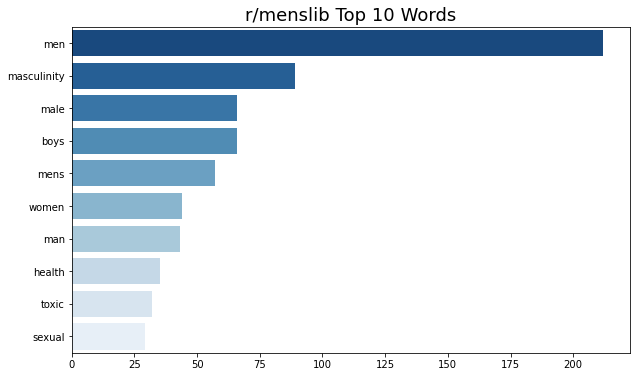

In [36]:
plot_top_words(menslib,'cleaned_title', 10, 1, 'r/menslib Top 10 Words', 'Blues_r')

In [37]:
stop_words = set(CountVectorizer(stop_words = 'english').get_stop_words())

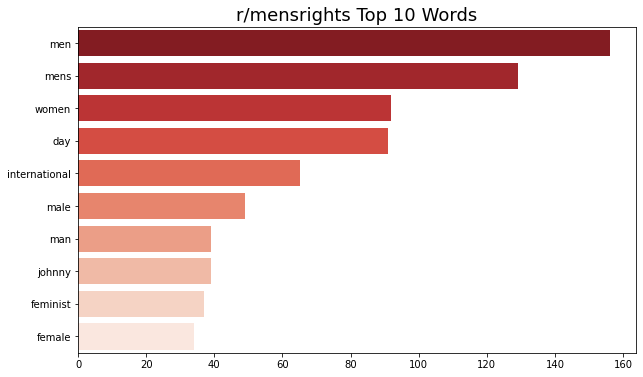

In [38]:
plot_top_words(mensrights,'cleaned_title', 10, 1, 'r/mensrights Top 10 Words', 'Reds_r')

There's a large amount overlap between the top words in `r/MensRights` and `r/MensLib` as expected. Namely, the focus on various male nouns e.g. men, mens, male, man. However, there's a much stronger focus on masculinity within `r/MensLib`. The subreddit also encompasses the issues of children, and focuses on issues affecting the physical and emotional health of men.

Within `r/MensRights`, the focus is much more topical. Topics that are common in the sub include the celebration of International Men's Day and the Johnny Depp & Amber Heard court case.

### Top Bigrams

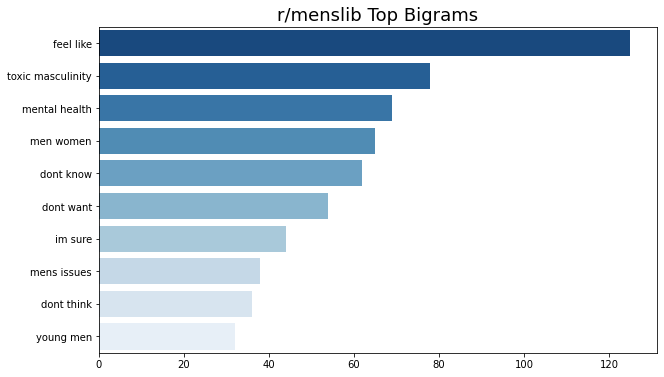

In [39]:
plot_top_words(menslib,'cleaned_selftext', 10, 2, 'r/menslib Top Bigrams', palette='Blues_r')

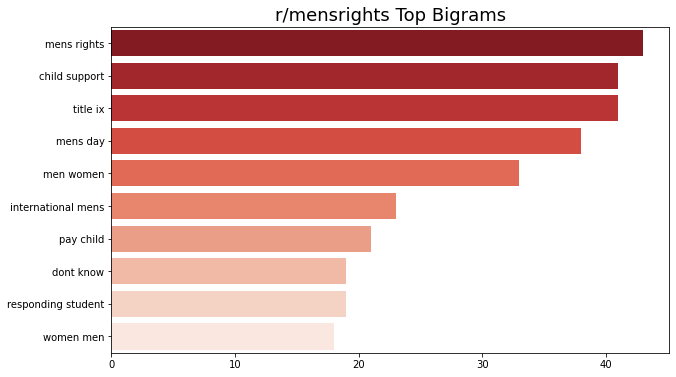

In [40]:
plot_top_words(mensrights,'cleaned_selftext', 10, 2, 'r/mensrights Top Bigrams', palette='Reds_r')

The relationship between men and women is important topic in each subreddit, though we can now see more of the key differences  based on the bigrams. The bigrams used within `r/MensLib` (e.g. don't know, don't think, don't want) along with their frequency (>40) are a likely indicator that the community is somewhat introspective.

For `r/MensRights`, key topical issues include men paying child support and sexual discrimination (Title IX is a US federal law that prohibits discrimination based on sex). Men's rights activists believe that Title IX is an [unfair law that denies proper due process and is a tool that is used indiscriminantly against men](https://www.nbcnews.com/news/us-news/men-s-rights-activists-are-attacking-women-s-scholarships-programs-n947886).

### Top Trigrams

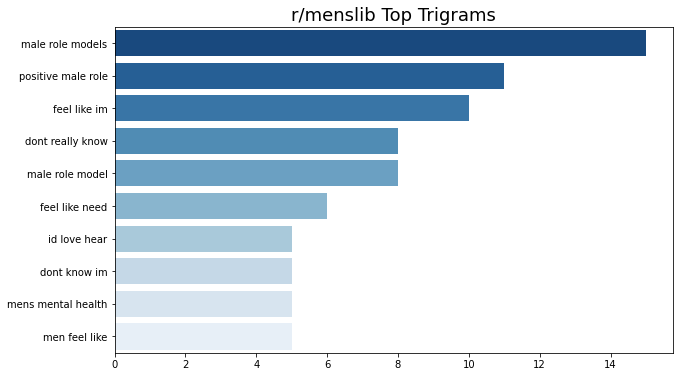

In [41]:
plot_top_words(menslib, 'cleaned_selftext', 10, 3, 'r/menslib Top Trigrams', 'Blues_r')

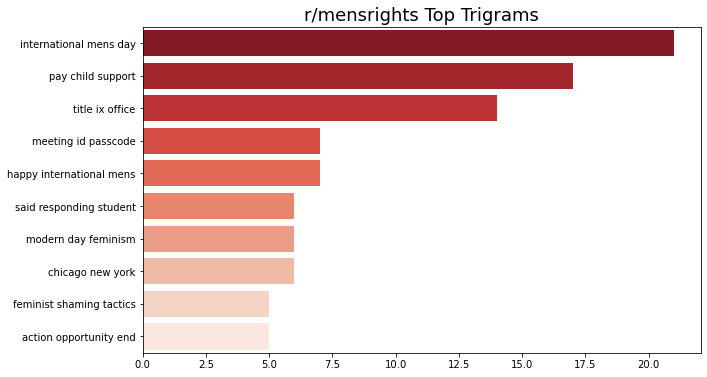

In [42]:
plot_top_words(mensrights,'cleaned_selftext', 10, 3, 'r/mensrights Top Trigrams', palette='Reds_r')

The focus on the emotional health of men is quite clear within `r/MensLib`. The frequent use of pronouns within the trigrams also suggest that personal issues and viewpoints are commonly discussed within the subreddit. In comparison, the trigrams for `r/MensRights` are factual and once again topical.

International Men's Day also seems to be a huge topic for `r/MensRights`. Within `r/MensLib`, the moderation team created a [single post](https://www.reddit.com/r/MensLib/comments/jxdphk/happy_international_mens_day_from_menslib/) that fulfilled the purpose of celebrating men's day, which is why we don't see mentions of it within our bigrams or trigrams.

Feminism as a movement seems to be also quite negatively viewed within the subreddit. This alludes to differences in sentiment between both subreddits that we'll explore further down.

## Analyzing Volume of Posts

In [43]:
# Retrieve posts scraped by PSAW
menslib_vdf = pd.read_csv('./datasets/menslib_vdf.csv')

In [44]:
mensrights_vdf = pd.read_csv('./datasets/mensrights_vdf.csv')

In [45]:
menslib_vdf.shape

(1371, 9)

In [46]:
# Clearly, the subreddits have much different levels of post traffic
mensrights_vdf.shape

(7060, 9)

In [47]:
# Saving date as string object
mensrights_vdf['string_date'] = mensrights_vdf['date']
menslib_vdf['string_date'] = menslib_vdf['date']

In [48]:
menslib_vdf['datetime'] = pd.to_datetime(menslib_vdf['date'])
menslib_vdf['date'] = menslib_vdf['datetime'].apply(lambda x: x.date())

In [49]:
mensrights_vdf['datetime'] = pd.to_datetime(mensrights_vdf['date'])
mensrights_vdf['date'] = mensrights_vdf['datetime'].apply(lambda x: x.date())

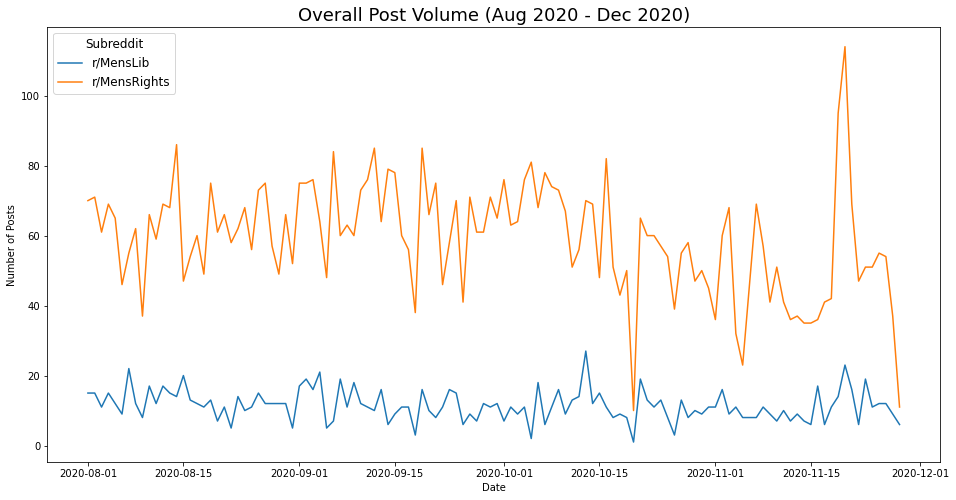

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
menslib_vdf['date'].value_counts().plot()
mensrights_vdf['date'].value_counts().plot()
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Overall Post Volume (Aug 2020 - Dec 2020)', fontsize=18)
legend = plt.legend(title='Subreddit', loc='best', labels=['r/MensLib', 'r/MensRights'], fontsize=12)
legend.get_title().set_fontsize('12')

The difference between the number of posts within each subreddit is quite obvious here. While arguably `r/MensLib` has higher quality posts (as indicated by higher upvotes and number of comments), `r/MensRights` has people posting much more frequently. This could be due to the strict moderation policy of `r/MensLib` which discourages users from making low-effort posts.

In [51]:
# There was a noticeable spike in posts from Nov 19 - Nov 21 -- this was likely due to International Men's Day on 19 Nov
mensrights_vdf['date'].value_counts().head()

2020-11-20    114
2020-11-19     95
2020-08-14     86
2020-09-12     85
2020-09-19     85
Name: date, dtype: int64

In [52]:
mensrights_vdf[mensrights_vdf['string_date'].str.contains('11-19|11-20')].head()

,date,title,selftext,is_self,upvotes,upvote_ratio,n_comments,permalink,author,string_date,datetime
6476,2020-11-19,Condemnation of UN'S treatment of ~~niggers~~ ...,NaN,0.0,0.0,0.50,16.0,/r/MensRights/comments/jwj755/condemnation_of_...,excess_inquisitivity,2020-11-19 00:44:41,2020-11-19 00:44:41
6477,2020-11-19,The divorce rate wouldn't be tilted to a woman...,There are men who feel trapped or at least co...,1.0,7.0,0.71,3.0,/r/MensRights/comments/jwjcd7/the_divorce_rate...,rockafault,2020-11-19 00:52:13,2020-11-19 00:52:13
6478,2020-11-19,ILLEGAL. Please all of you apply,NaN,0.0,1.0,1.00,4.0,/r/MensRights/comments/jwjmjm/illegal_please_a...,erikabrod,2020-11-19 01:06:33,2020-11-19 01:06:33
6479,2020-11-19,"It's International Men's Day, so tell me what ...",Happy imd from New Zealand! A couple of us hav...,1.0,15.0,1.00,89.0,/r/MensRights/comments/jwjv14/its_internationa...,dontpet,2020-11-19 01:18:16,2020-11-19 01:18:16
6480,2020-11-19,Casual Pedophilia in Hollywood Films,I don't know if this is the right place to pos...,1.0,5.0,0.86,17.0,/r/MensRights/comments/jwjxq4/casual_pedophili...,kaaari,2020-11-19 01:22:08,2020-11-19 01:22:08


#### Deleted Posts

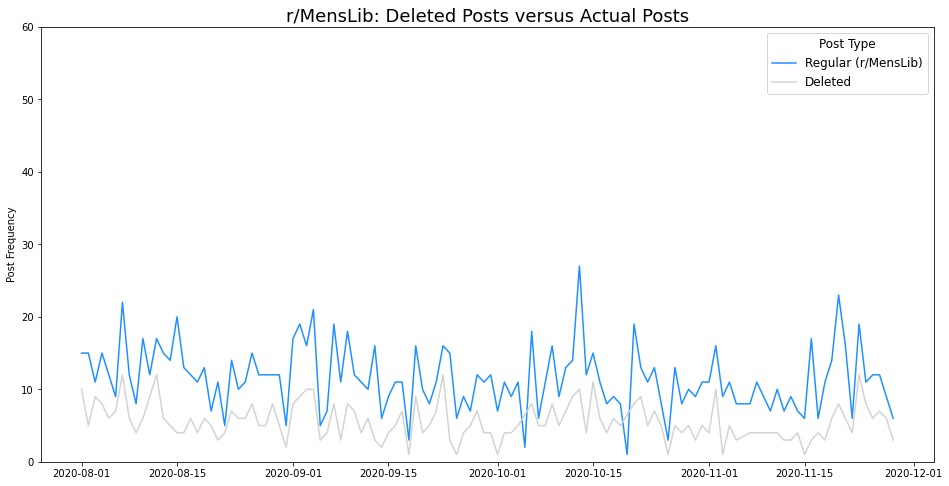

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
menslib_vdf['date'].value_counts().plot(color='dodgerblue')
menslib_vdf[(menslib_vdf['selftext'] == '[removed]') & (menslib_vdf['n_comments'] < 3)] \
            ['date'].value_counts().plot(color='lightgrey')
plt.title('r/MensLib: Deleted Posts versus Actual Posts', fontsize=18)
plt.ylabel('Post Frequency')
plt.ylim(0, 60)
legend = plt.legend(title='Post Type', loc='best', labels=['Regular (r/MensLib)', 'Deleted'], fontsize=12)
legend.get_title().set_fontsize('12')

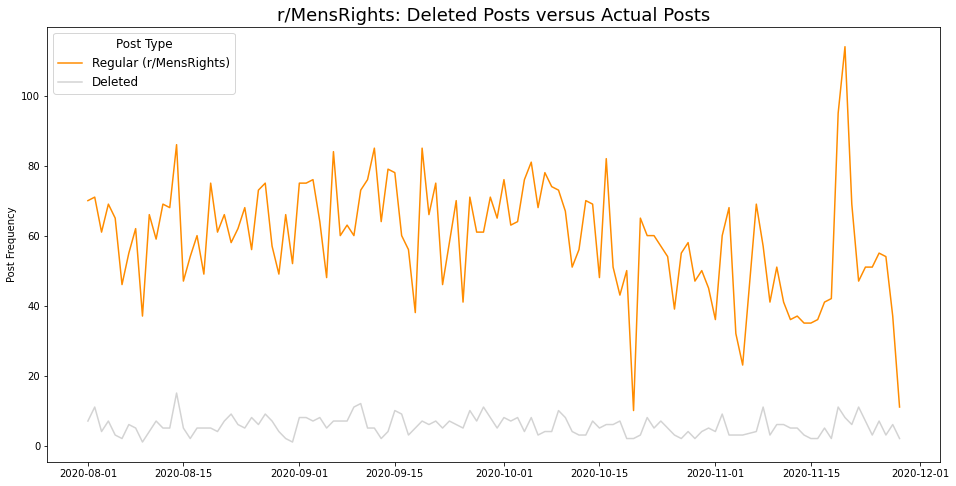

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
mensrights_vdf['date'].value_counts().plot(color='darkorange')
mensrights_vdf[(mensrights_vdf['selftext'] == '[removed]') & (mensrights_vdf['n_comments'] < 3)] \
            ['date'].value_counts().plot(color='lightgrey')
plt.title('r/MensRights: Deleted Posts versus Actual Posts', fontsize=18)
plt.ylabel('Post Frequency')
legend = plt.legend(title='Post Type', loc='best', labels=['Regular (r/MensRights)', 'Deleted'], fontsize=12)
legend.get_title().set_fontsize('12')

Within the posts that we scraped with PSAW from `r/MensLib`, a large number of these posts are either posts that have been deleted or removed. This is due to strict automoderation policy, as well as active efforts on the part of moderators to prevent the subreddit from being flooded with irrelevant content. In comparison, `r/MensRights` has a lot less removed/deleted posts. This could be due to more lenient moderation.

In [55]:
# Examples of removed posts
menslib_vdf[(menslib_vdf['selftext'] == '[removed]') & (menslib_vdf['n_comments'] < 3)].head()

,date,title,selftext,is_self,upvotes,upvote_ratio,n_comments,permalink,author,string_date,datetime
1,2020-08-01,I’ve notice some self projection from soically...,[removed],1.0,1.0,1.0,0.0,/r/MensLib/comments/i1bghz/ive_notice_some_sel...,Zero_The-Hero,2020-08-01 01:17:53,2020-08-01 01:17:53
3,2020-08-01,Why is Brie Larson painted as a Man Hater?,[removed],1.0,1.0,1.0,1.0,/r/MensLib/comments/i1ewcd/why_is_brie_larson_...,weeping_angel_fish,2020-08-01 04:27:09,2020-08-01 04:27:09
4,2020-08-01,Does anyone else have a messed up view of sex?...,[removed],1.0,1.0,1.0,1.0,/r/MensLib/comments/i1fbn3/does_anyone_else_ha...,fademeprobably,2020-08-01 04:51:04,2020-08-01 04:51:04
6,2020-08-01,I get a pit in my stomach when I hear that men...,[removed],1.0,1.0,1.0,2.0,/r/MensLib/comments/i1he0h/i_get_a_pit_in_my_s...,SketchySquidd,2020-08-01 06:51:46,2020-08-01 06:51:46
7,2020-08-01,Do any other guys here remember being casually...,[removed],1.0,1.0,1.0,1.0,/r/MensLib/comments/i1kvvx/do_any_other_guys_h...,bitheway4815,2020-08-01 10:47:31,2020-08-01 10:47:31


## Preparation for Sentiment Analysis

In [56]:
# Setting up target column
menslib['is_menslib'] = 1
mensrights['is_menslib'] = 0

In [57]:
combined_df = pd.concat([menslib, mensrights])
combined_df.head()

,date,title,selftext,is_self,upvotes,upvote_ratio,n_comments,distinguished,permalink,author,cleaned_title,cleaned_selftext,combi_text,lem_title,lem_selftext,lem_combi_text,is_menslib
0,2020-11-20 07:19:28,Happy International Men's Day from MensLib,"Officially, the theme is ""better health for me...",True,289,0.98,28,NaN,/r/MensLib/comments/jxdphk/happy_international...,delta_baryon,happy international mens day from menslib,officially the theme is better health for men ...,happy international mens day from menslib offi...,happy international men day menslib,officially theme better health men boy mod tea...,happy international men day menslib officially...,1
2,2020-11-26 19:30:45,Red Hot Chilli Piper: Women grope me under my ...,,False,1833,0.98,133,NaN,/r/MensLib/comments/k1dowk/red_hot_chilli_pipe...,delta_baryon,red hot chilli piper women grope me under my kilt,,red hot chilli piper women grope me under my k...,red hot chilli piper woman grope kilt,,red hot chilli piper woman grope kilt,1
3,2020-11-26 01:42:38,Black male teachers can have a profound impact...,,False,3290,0.97,143,NaN,/r/MensLib/comments/k0wsxs/black_male_teachers...,TAKEitTOrCIRCLEJERK,black male teachers can have a profound impact...,,black male teachers can have a profound impact...,black male teacher profound impact classroom u...,,black male teacher profound impact classroom u...,1
4,2020-11-27 01:11:46,Musing on masculinity and coopetition.,The topic of human social competition has very...,True,16,0.84,1,NaN,/r/MensLib/comments/k1j29y/musing_on_masculini...,Shieldheart-,musing on masculinity and coopetition,the topic of human social competition has very...,musing on masculinity and coopetition the topi...,musing masculinity coopetition,topic human social competition whirled noggin ...,musing masculinity coopetition topic human soc...,1
5,2020-11-24 22:37:48,Trans man loses UK legal battle to register as...,,False,1918,0.98,216,NaN,/r/MensLib/comments/k064hr/trans_man_loses_uk_...,delta_baryon,trans man loses uk legal battle to register as...,,trans man loses uk legal battle to register as...,trans man loses uk legal battle register child...,,trans man loses uk legal battle register child...,1


In [58]:
combined_df['og_text'] = combined_df['title'] + '\n\n' + combined_df['selftext']

In [59]:
# Final check for null values
combined_df.isnull().sum()[combined_df.isnull().sum() > 0]

distinguished    1656
author             41
dtype: int64

In [60]:
combined_df.to_csv('./datasets/combined_df.csv', index=False)

## Sentiment Analysis

There seems to be a clear difference in sentiment between both subreddits, both how can we prove this? In the field on NLP, there are various tools that try to gauge sentiment. The tool that I'm using is the NLTK sentiment analyzer, also known as <b>VADER (Valence Aware Dictionary and sEntiment Reasoner)</b>, which is a lexicon (dictionary of sentiments in this case) and a simple rule-based model for general sentiment analysis. 

VADER is able to give us a Positivity and Negativity score that can be standardized in a range of -1 to 1. VADER is able to include sentiments from emoticons (e.g, :-D), sentiment-related acronyms (e.g, LoL) and slang (e.g, meh) where algorithms typically struggle. This makes it a good fit for the casual language that's being used across both subreddits.

In [61]:
sentiment_df = combined_df[['combi_text', 'og_text', 'is_menslib']].reset_index(drop=True)

In [62]:
# Initialise VADER
sid = SentimentIntensityAnalyzer()

By calling the SentimentIntensityAnalyzer() on each post, we can retrieve the proportion of text that falls in the negative, neutral or positive category. From this, we can also retreive the compound score of each post, which is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 and 1. In short, compound scores are the sum of valence computed based on internal heuristics and a sentiment lexicon.

Based on the compound score, we can then create a categorical feature - `comp_score` - that reflects whether a post is overall positive or negative based on compound score.

In [63]:
# Analyzing sentiment with VADER
sentiment_df['scores'] = sentiment_df['combi_text'].apply(lambda post: sid.polarity_scores(post))
sentiment_df['compound']  = sentiment_df['scores'].apply(lambda score_dict: score_dict['compound'])
sentiment_df['comp_score'] = sentiment_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [64]:
sentiment_df['subreddit'] = sentiment_df['is_menslib'].apply(lambda x: 'r/MensLib' if x == 1 else 'r/MensRights')

In [65]:
sentiment_df.head()

,combi_text,og_text,is_menslib,scores,compound,comp_score,subreddit
0,happy international mens day from menslib offi...,Happy International Men's Day from MensLib\n\n...,1,"{'neg': 0.014, 'neu': 0.926, 'pos': 0.059, 'co...",0.7184,pos,r/MensLib
1,red hot chilli piper women grope me under my k...,Red Hot Chilli Piper: Women grope me under my ...,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,r/MensLib
2,black male teachers can have a profound impact...,Black male teachers can have a profound impact...,1,"{'neg': 0.167, 'neu': 0.833, 'pos': 0.0, 'comp...",-0.3400,neg,r/MensLib
3,musing on masculinity and coopetition the topi...,Musing on masculinity and coopetition.\n\nThe ...,1,"{'neg': 0.087, 'neu': 0.694, 'pos': 0.219, 'co...",0.9993,pos,r/MensLib
4,trans man loses uk legal battle to register as...,Trans man loses UK legal battle to register as...,1,"{'neg': 0.318, 'neu': 0.584, 'pos': 0.097, 'co...",-0.5267,neg,r/MensLib


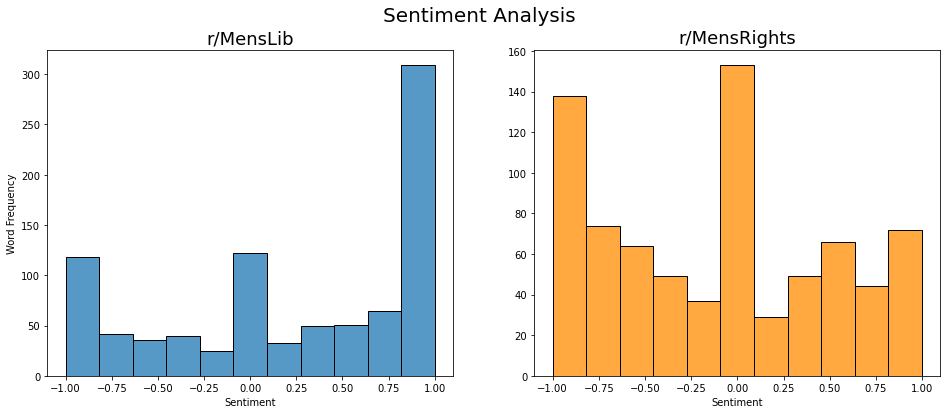

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.ravel()
sns.histplot(sentiment_df[sentiment_df['is_menslib'] == 1]['compound'].values, ax = ax[0])
sns.histplot(sentiment_df[sentiment_df['is_menslib'] == 0]['compound'].values, color='darkorange', ax = ax[1])
ax[0].set_title('r/MensLib', fontsize=18)
ax[1].set_title('r/MensRights', fontsize=18)
ax[0].set_xlabel('Sentiment')
ax[0].set_ylabel('Word Frequency')
ax[1].set_xlabel('Sentiment')
ax[1].set_ylabel('')
plt.suptitle('Sentiment Analysis', fontsize=20);

Our assumption seems to have been largely correct here -- the sentiment within `r/MensLib` seems to be much more positive. Most posts tend towards the right side of the graph, with a large number of posts having a high positive sentiment score between 0.8 and 1.0. In comparison, `r/MensRights` has a large number of posts that are strongly negative, and relatively fewer posts that are strongly positive.

In [67]:
# We can also see that the average sentiment within r/MensLib is much higher.
sentiment_df[sentiment_df['is_menslib']==1]['compound'].mean(), sentiment_df[sentiment_df['is_menslib']==0]['compound'].mean()

(0.24337977528089888, -0.1086163870967742)

In [68]:
# Example of a strongly negative post within r/MensLib.
# As a whole, this post isn't actually 'negative' despite the negative sentiment that VADER is detecting.
temp_df = sentiment_df[(sentiment_df['subreddit'] == 'r/MensLib') 
                       & (sentiment_df['compound'] < -0.9)]['og_text'].reset_index()
print(temp_df['og_text'][6])

As a man, I cry in front of people whenever I feel like it. It's refreshing

I was fired yesterday and cried in front of my ex-boss.

If I feel like crying (i.e. when I'm suffering) I bloody well will do so.

Crying is a natural defense mechanism against suffering. Denying men the ability to cry in front of people, in this day and age, just completely obliterates their ability to process their emotions. I have a theory that if we don't cry, we then must put that bad energy elsewhere, like into aggression and latent resentment, which will inevitably hurt others.

There are two ways to cry:

* You can cry involuntarily, which leads to looking like you're constantly holding it back, ashamed and hyper-aware of what everyone thinks of the crying, which will just make things even more awkward
* You can cry completely unashamedly, showing that you do not care on a meta-level what anyone thinks of your crying or how you look.

This isn't to advocate crying at spilt milk, or at every damn thing

In [69]:
# Example of a strongly negative or 'angry' post within r/MensRights.
temp_df2 = sentiment_df[(sentiment_df['subreddit'] == 'r/MensRights') 
                        & (sentiment_df['compound'] < -0.9)]['og_text'].reset_index()
print(temp_df2['og_text'][17])

Men's problems don't matter apparently

People (even other men) use "be a man" to shut up men who talk about their own problems, this makes them unable to get anything off their chest and can lead to suicide, self harm or violence.

More men die of COVID-19 but it affects women more.

Millions of men die in wars, have to watch their friend die in front of them and kill children in battle but women are the real survivors.

Men are expected to provide for the whole family, keep a job, fight for promotions, work on someone else's schedule and pay for everything but women do all the real work.

Women are valued for being alive while men have to work extremely hard to be valued but women have such a hard life and men have it easy.

My point is that men are expected to always deal with their own problems because "men never need help". **Men *do* have problems, you will figure out that every man has problems if you let him speak.**


#### Sentiment Visualization with Scattertext

To get a better grasp of the words and the sentiment behind them across both subreddits, we'll use a tool called Scattertext. Scattertext can help visualize what words and phrases are more characteristic of a category than others. Below, we'll try to visualize sentiment across both subreddits and see what are the most 'positive' and 'negative' words.

Scattertext uses <b>scaled f-score (the harmonic mean between precision and recall)</b>, which takes into account category-specific precision and term frequency when ranking words. A detailed explanation of the formula behind scaled f-score can be found [here](https://github.com/JasonKessler/PuPPyTalk/blob/master/notebooks/Class-Association-Scores.ipynb). 

In this case, we'll be looking to compare positive and negative sentiment posts. While a word may appear frequently in either the negative or positive category, Scattertext can use scaled f-score to detect whether a particular term is more characteristic of a particular category.

In [70]:
nlp = spacy.load('en')

In [71]:
# Build corpus for Scattertext sentiment analysis
corpus = st.CorpusFromPandas(sentiment_df, category_col='comp_score', text_col='combi_text', nlp=nlp).build()

In [72]:
html = st.produce_scattertext_explorer(corpus, 
                                       category='pos', 
                                       category_name='Positive', 
                                       not_category_name='Negative',
                                       width_in_pixels=1000, 
                                       metadata=sentiment_df['subreddit'],
                                       save_svg_button=True)

In [73]:
html_file_name = "Project_3_Sentiment_Analysis_v2.html"
open(html_file_name, 'wb').write(html.encode('utf-8'))

2767384

The blue dots represent words that have been ranked as positive, while the red dots represent words that have been ranked as negative. As a general observation, the words in blue seem to be used more frequently within r/MensLib, while the words in red are used more frequently within r/MensRights.

For example, while the word 'feminist' is frequent across both 'negative' and 'positive' categories, Scattertext concludes that 'feminist' belong in the 'negative' category due to it's scaled f-score of -0.1.

The interactive version of this chart can be viewed within your browser [here](./assets/Project_3_Sentiment_Analysis.html).

<img src='./assets/sentiment_analysis.png'>

In [74]:
sentiment_df['is_menslib'].corr(sentiment_df['compound'])

0.2567485781174059

We can see that clearly, a correlation does exist between sentiment and whether a post comes from either `r/MensLib` or `r/MensRights`.

In [75]:
# Saving for further analysis in next notebook
sentiment_df.to_csv('sentiment_df.csv', index=False)

In [ ]:
## Alteratively, you may run this cell to view the interactive version of this chart within the notebook ##
IFrame(src='./assets/Project_3_Sentiment_Analysis.html', width=1000, height=800)